In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('BMRI.JK.csv')

print(data)


            Date    Open    High     Low   Close    Adj Close     Volume
0     2019-01-01  3687.5  3687.5  3687.5  3687.5  2840.737305          0
1     2019-01-02  3700.0  3700.0  3625.0  3662.5  2821.477783   45319200
2     2019-01-03  3637.5  3675.0  3550.0  3587.5  2763.700439   74174000
3     2019-01-04  3587.5  3725.0  3575.0  3725.0  2869.626221   78514000
4     2019-01-07  3750.0  3787.5  3712.5  3712.5  2859.996582   53624800
...          ...     ...     ...     ...     ...          ...        ...
1463  2024-12-19  5625.0  5725.0  5600.0  5675.0  5675.000000  277793000
1464  2024-12-20  5675.0  5750.0  5625.0  5675.0  5675.000000  148568600
1465  2024-12-23  5800.0  5875.0  5725.0  5825.0  5825.000000   82910100
1466  2024-12-24  5825.0  5875.0  5750.0  5750.0  5750.000000   41240900
1467  2024-12-27  5750.0  5850.0  5750.0  5800.0  5800.000000   46126800

[1468 rows x 7 columns]


In [3]:
data = data.ffill()

X = data.drop(['Date', 'Close'], axis=1)
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression MAE: {mae_lr}, MSE: {mse_lr}, RMSE: {rmse_lr}, R²: {r2_lr}')

Linear Regression MAE: 24.51580533265612, MSE: 1040.2981367416255, RMSE: 32.253653075917235, R²: 0.9994609528627644


In [5]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regressor MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R²: {r2_rf}')


Random Forest Regressor MAE: 20.051445578231288, MSE: 949.1936840986394, RMSE: 30.80898706706599, R²: 0.9995081600937034


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['Close']])

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60 
X_lstm, y_lstm = create_dataset(scaled_data, look_back)

train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(Input(shape=(look_back, 1)))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=2)

y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

y_test_lstm = np.reshape(y_test_lstm, (-1, 1))
y_test_lstm = scaler.inverse_transform(y_test_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f'LSTM MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, R²: {r2_lstm}')


Epoch 1/20
36/36 - 9s - 256ms/step - loss: 0.0203
Epoch 2/20
36/36 - 1s - 38ms/step - loss: 0.0012
Epoch 3/20
36/36 - 1s - 39ms/step - loss: 8.2880e-04
Epoch 4/20
36/36 - 1s - 40ms/step - loss: 8.3833e-04
Epoch 5/20
36/36 - 1s - 39ms/step - loss: 7.6711e-04
Epoch 6/20
36/36 - 1s - 39ms/step - loss: 7.3863e-04
Epoch 7/20
36/36 - 1s - 38ms/step - loss: 7.1047e-04
Epoch 8/20
36/36 - 1s - 40ms/step - loss: 7.0532e-04
Epoch 9/20
36/36 - 1s - 40ms/step - loss: 6.3277e-04
Epoch 10/20
36/36 - 1s - 41ms/step - loss: 6.5026e-04
Epoch 11/20
36/36 - 2s - 43ms/step - loss: 6.1229e-04
Epoch 12/20
36/36 - 1s - 41ms/step - loss: 5.8108e-04
Epoch 13/20
36/36 - 1s - 41ms/step - loss: 5.7499e-04
Epoch 14/20
36/36 - 2s - 42ms/step - loss: 6.3406e-04
Epoch 15/20
36/36 - 1s - 41ms/step - loss: 5.7360e-04
Epoch 16/20
36/36 - 1s - 41ms/step - loss: 5.6630e-04
Epoch 17/20
36/36 - 2s - 42ms/step - loss: 5.4318e-04
Epoch 18/20
36/36 - 1s - 39ms/step - loss: 5.1494e-04
Epoch 19/20
36/36 - 1s - 40ms/step - loss: 5

In [7]:
results = {
    'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
    'MAE': [mae_lr, mae_rf, mae_lstm],
    'MSE': [mse_lr, mse_rf, mse_lstm],
    'RMSE': [rmse_lr, rmse_rf, rmse_lstm],
    'R²': [r2_lr, r2_rf, r2_lstm]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model         MAE           MSE        RMSE        R²
0  Linear Regression   24.515805   1040.298137   32.253653  0.999461
1      Random Forest   20.051446    949.193684   30.808987  0.999508
2               LSTM  143.596113  32836.576243  181.208654  0.871161


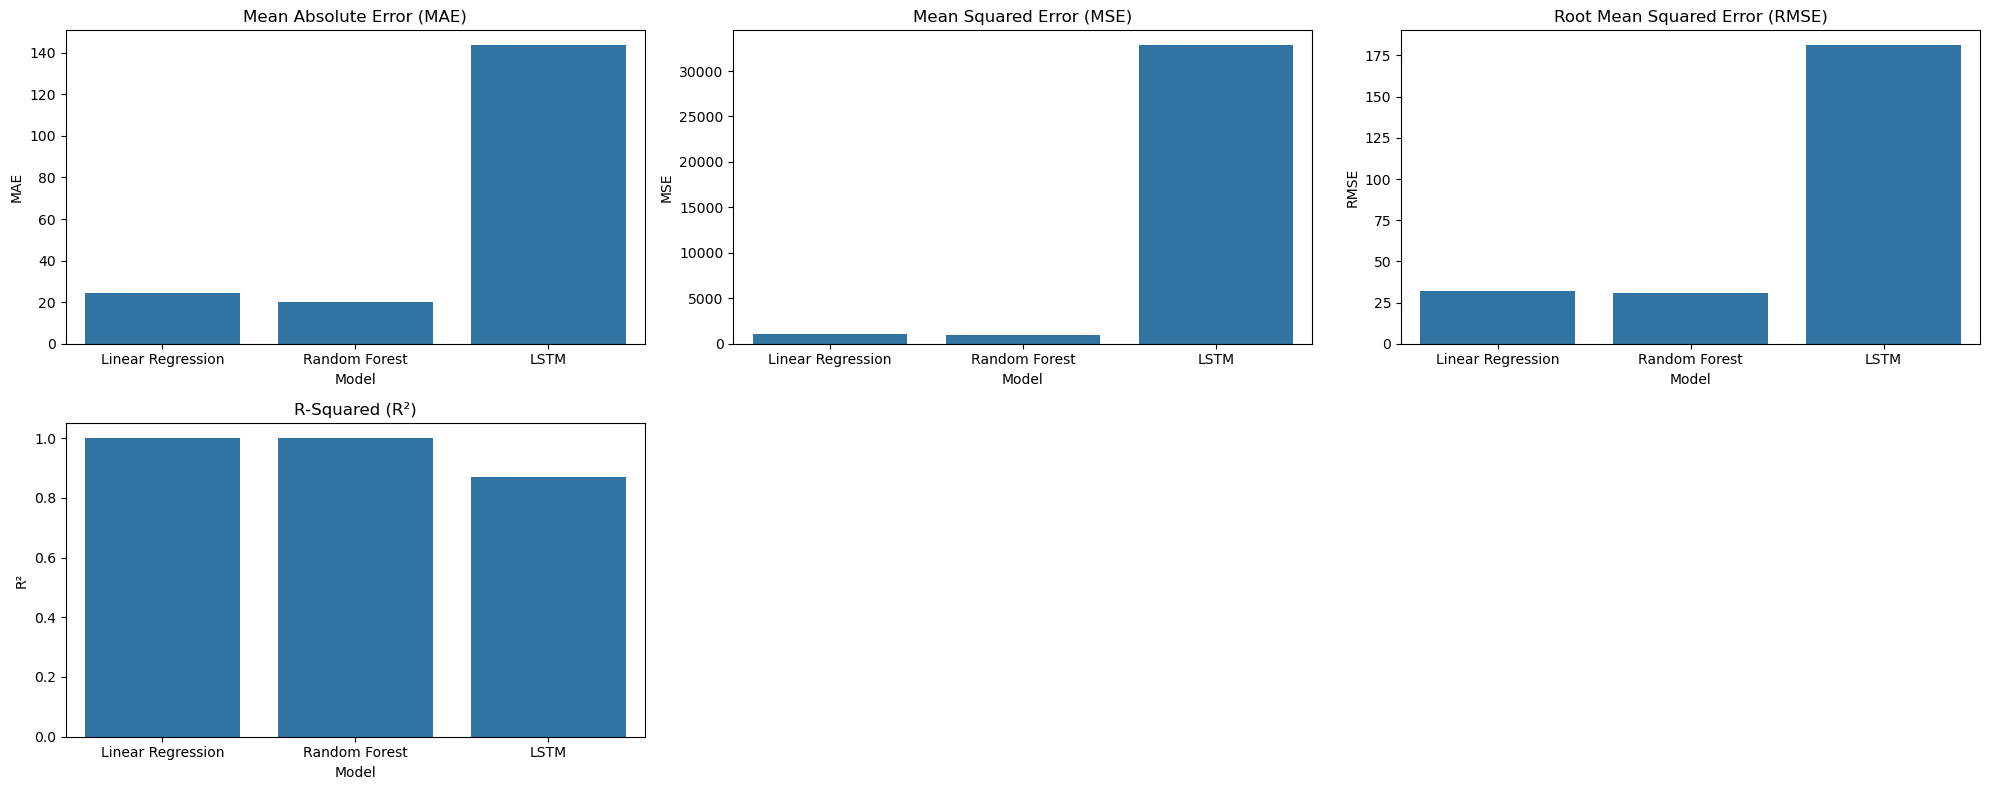

In [8]:
plt.figure(figsize=(20, 8))

plt.subplot(2, 3, 1)
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Model')

plt.subplot(2, 3, 2)
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Model')

plt.subplot(2, 3, 3)
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Model')

plt.subplot(2, 3, 4)
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('R-Squared (R²)')
plt.ylabel('R²')
plt.xlabel('Model')

plt.tight_layout()
plt.show()
